# Text Mining Project - Stock Sentiment

- Tomás Silva 20230982
- Martim Tavares 20240508
- Santiago Taylor 20240542
- Rita Palma 20240661

# Library and Data Imports

In [ ]:
# !pip uninstall -y datasets

In [ ]:
# !pip install datasets==2.16.1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split

# Classical ML
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score

import torch

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

# Transformer (Hugging Face)
from transformers import (AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding, logging as hf_logging)

from datasets import Dataset
from datasets import Dataset as HFDataset
hf_logging.set_verbosity_error()


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
train_df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [ ]:
test_df.head()

,id,text
0,0,ETF assets to surge tenfold in 10 years to $50...
1,1,Here’s What Hedge Funds Think Evolution Petrol...
2,2,$PVH - Phillips-Van Heusen Q3 2020 Earnings Pr...
3,3,China is in the process of waiving retaliatory...
4,4,"Highlight: “When growth is scarce, investors s..."


# RoBERTa

In [ ]:
X_train = train_df["text"]
y_train = train_df["label"]

In [ ]:
train_data = Dataset.from_dict({"text": X_train.tolist(), "label": y_train.tolist()}) # Convert to list

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

train_data = train_data.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    f1 = f1_score(labels, preds, average="macro")
    return {"f1": f1}


In [ ]:
final_model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)

training_args = TrainingArguments(
    output_dir="./roberta-sentiment-final",
    eval_strategy="no",
    save_strategy="no",
    learning_rate=2.2480367075223853e-05,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.27685297480310544,
    report_to="none",
    load_best_model_at_end=True,
)

final_trainer = Trainer(
    model=final_model,
    args=training_args,
    train_dataset=train_data,
    # The default DataCollatorWithPadding will be used, which handles padding and tensor conversion
    compute_metrics=compute_metrics
)

final_trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

{'loss': 0.3972, 'grad_norm': 12.854159355163574, 'learning_rate': 1.3101016598186476e-05, 'epoch': 1.6722408026755853}
{'loss': 0.174, 'grad_norm': 2.0203640460968018, 'learning_rate': 3.7028698276079423e-06, 'epoch': 3.3444816053511706}
{'train_runtime': 742.8171, 'train_samples_per_second': 51.388, 'train_steps_per_second': 1.61, 'train_loss': 0.2574033992346314, 'epoch': 4.0}


TrainOutput(global_step=1196, training_loss=0.2574033992346314, metrics={'train_runtime': 742.8171, 'train_samples_per_second': 51.388, 'train_steps_per_second': 1.61, 'train_loss': 0.2574033992346314, 'epoch': 4.0})

In [ ]:
# Evaluation helper
def evaluate(y_true, y_pred, title="Model"):
    print(f"\n=== {title} ===")
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(title)
    plt.show()


=== RoBERTa (train) ===
              precision    recall  f1-score   support

           0      0.962     0.971     0.967      1442
           1      0.947     0.983     0.965      1923
           2      0.992     0.978     0.985      6178

    accuracy                          0.978      9543
   macro avg      0.967     0.977     0.972      9543
weighted avg      0.978     0.978     0.978      9543



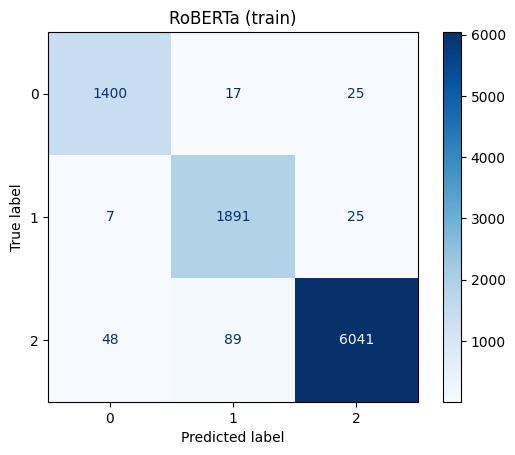

In [ ]:
preds_train = final_trainer.predict(train_data)
roberta_pred_train = preds_train.predictions.argmax(axis=-1)

evaluate(y_train, roberta_pred_train, title="RoBERTa (train)")

In [ ]:
def metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro'), precision_score(y_true, y_pred, average='macro'), recall_score(y_true, y_pred, average='macro')

rows_train = []
for name, pred in [("RoBERTa", roberta_pred_train)]:
    acc_train, f1_train, prec_train, rec_train = metrics(y_train, pred)
    rows_train.append({"Model": name, "Accuracy": acc_train, "Macro F1": f1_train, "Precision": prec_train, "Recall": rec_train})

comp_df_train = pd.DataFrame(rows_train)
print("--------Train scores-------- \n", comp_df_train.to_string(index=False))


--------Train scores-------- 
   Model  Accuracy  Macro F1  Precision   Recall
RoBERTa   0.97789  0.972024    0.96697 0.977353


# Get predictions for test set

In [ ]:
# Prepare the test data for the model
X_test = test_df["text"]
test_data = Dataset.from_dict({"text": X_test.tolist()})
test_data = test_data.map(tokenize, batched=True)

# Predict the labels using the trained model
preds_test = final_trainer.predict(test_data)
roberta_pred_test = preds_test.predictions.argmax(axis=-1)  # Get predicted class labels

# Using the index of test_df to guarantee that indexes are correct
submission_df = pd.DataFrame({
    "index": test_df.index,
    "prediction": roberta_pred_test
})

# Create a CSV
submission_df.to_csv("pred_09.csv", index=False)

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

=== Label Distribution Comparison ===
   Train Label Proportion  Test Prediction Proportion
0                0.151106                    0.157454
1                0.201509                    0.210218
2                0.647386                    0.632328


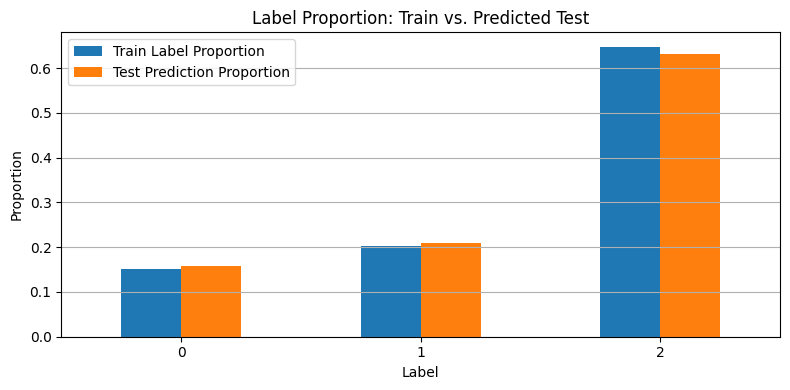

In [ ]:
# Comparing train label distributions to test test prediciton distributions (to check for potential overfitting)
train_label_dist = train_df["label"].value_counts(normalize=True).sort_index()
test_pred_dist = pd.Series(roberta_pred_test).value_counts(normalize=True).sort_index()

# Combine into one DataFrame for comparison
label_comparison = pd.DataFrame({
    "Train Label Proportion": train_label_dist,
    "Test Prediction Proportion": test_pred_dist
}).fillna(0)  # In case a class wasn't predicted at all


print("=== Label Distribution Comparison ===")
print(label_comparison.to_string())

label_comparison.plot(kind="bar", figsize=(8, 4), title="Label Proportion: Train vs. Predicted Test")
plt.ylabel("Proportion")
plt.xlabel("Label")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()